# mathematical model

Let the plane generating the light source to be $z=z_s$, and the plane where the light gets refracted onto $z=z_o$. The surface is parameterised by $(x,y,f(x,y))$. For simplicity, we will assume that surface remains above $z=z_o$, at least for the subset of the the plane where we consider incoming light. 

For each point $(x,y,z_s)$ on the source plane, we're interested in where the light ray appears on the plane $z=z_o$. Let $g$ be the function that maps $(x,y)$ to its corresponding point on $z=z_o$. 

A normal vector to the surface is $\bold{n}=\left(-\frac{\partial f}{\partial x}, -\frac{\partial f}{\partial y}, 1\right)$, thus the angle $\theta_i$ between the normal to the surface and the incoming ray is $$\cos^{-1}\left({\frac{\hat{\bold{z}} . \bold{n}}{\|\bold{n}\|\|\hat{\bold{z}}\|}}\right) = \cos^{-1}\left(\sqrt{\frac{1}{1+\|\nabla f\|^2}}\right).$$

If $\theta_i$ is the angle of the incoming light ray, then $\theta_r=\sin^{-1}\left(\frac{n_i}{n_r}\sin\theta_i\right)$. The function $g$ is then 

$$g(x,y) = (x,y,z_o) + \left(f(x,y) - z_o\right)\tan\left(\theta_r\right)\left(\frac{\hat{\bold{z}}-\bold{n}}{\|\hat{\bold{z}}-\bold{n}\|}\right) = (x,y,z_o) + \left(f(x,y) - z_o\right)\tan\left(\theta_r\right)\left(\frac{\nabla f}{\|\nabla f\|}\right).$$

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [110]:

def grad(f, X, Y, h=1e-4):
    """Computes the gradient of f using central differencing."""
    fx = (f(X + h, Y) - f(X - h, Y)) / (2 * h)
    fy = (f(X, Y + h) - f(X, Y - h)) / (2 * h)
    return np.stack([fx, fy], axis=-1)  # Shape (N, M, 2)


def map_ray(X, Y, f, z_s=1, z_o=-1, n_r=1.33):
    """Computes the refracted ray landing positions for all points in X, Y."""
    grad_f = grad(f, X, Y)
    grad_norm_sq = np.sum(grad_f**2, axis=-1)

    # Flat surface mask: If gradient is zero, the ray continues straight down
    flat_mask = np.isclose(grad_norm_sq, 0)
    
    # Compute incoming angles
    theta_i = np.arccos(1 / np.sqrt(1 + grad_norm_sq), where=~flat_mask, out=np.zeros_like(grad_norm_sq))
    
    # Valid refraction mask (not TIR, not flat)
    valid_mask = ~flat_mask

    # Compute refracted angles (Snell's law)
    theta_r = np.zeros_like(theta_i)
    theta_r[valid_mask] = np.arcsin((1 / n_r) * np.sin(theta_i[valid_mask]))

    # Compute displacement for valid refractions
    displacement = np.zeros_like(grad_f)
    scale_factor = np.zeros_like(grad_norm_sq)
    scale_factor[valid_mask] = (f(X[valid_mask], Y[valid_mask]) - z_o) * np.tan(theta_r[valid_mask]) / np.sqrt(grad_norm_sq[valid_mask])
    displacement[valid_mask] = grad_f[valid_mask] * np.expand_dims(scale_factor[valid_mask], axis=-1)

    # Compute new positions
    image_pts = np.stack([X, Y], axis=-1) + displacement

    # For flat regions, return the same (x, y) since the ray continues straight
    image_pts[flat_mask] = np.stack([X[flat_mask], Y[flat_mask]], axis=-1)

    return image_pts[valid_mask | flat_mask]  # Remove only TIR cases


def get_image(f, x_range, y_range, resolution=100, z_s=1, z_o=-1, n_r=1.33):
    """Computes the refracted image for a grid of incident points."""
    x_grid = np.linspace(x_range[0], x_range[1], resolution)
    y_grid = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x_grid, y_grid)
    return map_ray(X, Y, f, z_s, z_o, n_r)


In [193]:
def plot_refracted_image(image_points, xlim=None, ylim=None, bins=300, sigma=1.0):
    # Extract refracted (x', y') positions
    x_refracted, y_refracted = image_points[:, 0], image_points[:, 1]

    # Set default limits based on data if not provided
    if xlim is None:
        xlim = (x_refracted.min(), x_refracted.max())
    if ylim is None:
        ylim = (y_refracted.min(), y_refracted.max())

    # Clip points to remove artificial edges
    mask = (x_refracted >= xlim[0]) & (x_refracted <= xlim[1]) & \
           (y_refracted >= ylim[0]) & (y_refracted <= ylim[1])
    x_refracted, y_refracted = x_refracted[mask], y_refracted[mask]

    # Compute 2D histogram
    hist, xedges, yedges = np.histogram2d(x_refracted, y_refracted, bins=bins, density=True)

    # Apply Gaussian filter for smoothing
    hist_smoothed = ndimage.gaussian_filter(hist, sigma=sigma)

    # Plot the smoothed density map
    plt.figure(figsize=(8, 6))
    plt.imshow(hist_smoothed.T, origin="lower", extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
               cmap="Blues_r", aspect="auto")

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Smoothed Density of Refracted Rays")
    plt.colorbar(label="Density")
    #plt.grid(True)
    plt.show()


In [194]:
def f(x,y):
  return (x+y)**2

image_pts = get_image(f, x_range=[-8,8], y_range=[-8,8], resolution=800)

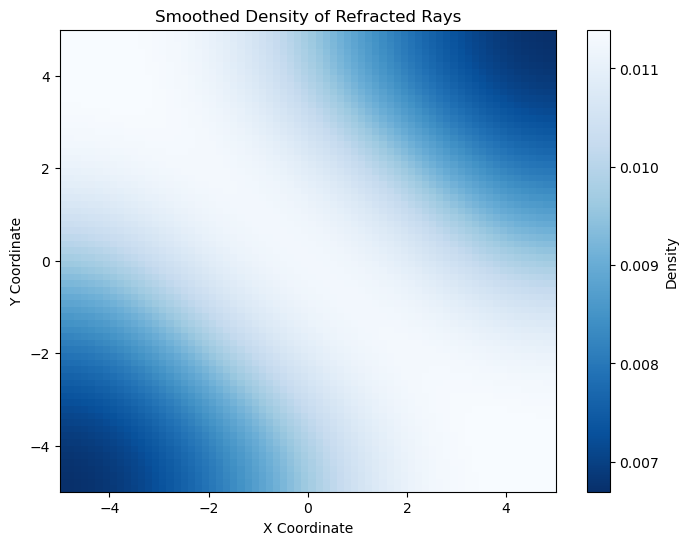

In [195]:
plot_refracted_image(image_points=image_pts, xlim=[-5,5], ylim=[-5,5], bins=70, sigma=10)